## Environment setup

In [ ]:
!pip install roboflow

from roboflow import Roboflow
import cv2
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from IPython.display import Image
import numpy as np
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import cv2
import colorsys
import random
import matplotlib.pyplot as plt
import numpy as np

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
os.environ["ROBOFLOW_API_KEY"] = "ROBOFLOW_API_KEY"

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Thu Mar  6 14:57:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P3              8W /   41W |    5891MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install git+https://github.com/sunsmarterjie/yolov12.git
!pip install roboflow
!pip install supervision
!pip install flash-attn --no-build-isolation --no-cache-dir
!pip install huggingface_hub




  Cloning https://github.com/sunsmarterjie/yolov12.git to c:\users\manus\appdata\local\temp\pip-req-build-k07wwj4g
  Resolved https://github.com/sunsmarterjie/yolov12.git to commit 3a336a4adf3683d280e1a50d03fa24bbe7f24a5b
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/sunsmarterjie/yolov12.git 'C:\Users\Manus\AppData\Local\Temp\pip-req-build-k07wwj4g'


     ---------------------------------------- 0.0/6.0 MB ? eta -:--:--
     ---------------------------------------- 6.0/6.0 MB 121.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      
      
      torch.__version__  = 2.5.1
      
      
      C:\Users\Manus\AppData\Local\Temp\pip-install-qhq937xb\flash-attn_a1eba2ab7b46467c9261d89f0bc09acc\setup.py:106: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Manus\AppData\Local\Temp\pip-install-qhq937xb\flash-attn_a1eba2ab7b46467c9261d89f0bc09acc\setup.py", line 198, in <module>
          CUDAExtension(
        File "c:\Users\Manus\anaconda3\Lib\site-packages\torch\utils\cpp_exten

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv

In [ ]:
dataset_location = r"..\project\dataset_plates"
HOME = r"..\project\test_model"
!dir "{HOME}\runs\detect\train"

 Volume in drive C is Windows
 Volume Serial Number is ACE5-C045

 Directory of c:\Manus\deep_learning\project\test_model\runs\detect\train

03/06/2025  03:05 PM    <DIR>          .
03/06/2025  03:05 PM    <DIR>          ..
03/04/2025  03:57 PM            84,543 confusion_matrix.png
03/04/2025  03:57 PM           275,860 results.png
03/06/2025  03:05 PM    <DIR>          weights
               2 File(s)        360,403 bytes
               3 Dir(s)  92,952,641,536 bytes free


In [ ]:
# Define the file path
file_path = f"{dataset_location}\data.yaml"

# Open the file to read the lines
with open(file_path, "r") as f:
    lines = f.readlines()

# Remove the last four lines
lines = lines[:-4]

# Append the new lines
lines.append("test: ../test/images\n")
lines.append("train: ../train/images\n")
lines.append("val: ../valid/images\n")

# Write the updated content back to the file
with open(file_path, "w") as f:
    f.writelines(lines)

print("File updated successfully!")


File updated successfully!


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [11]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\Manus\\AppData\\Local\\Temp\\pip-install-prjwp9wt\\flash-attn_144808faecef47f0b0c07972b03a64df\\csrc\\composable_kernel\\library\\include\\ck\\library\\tensor_operation_instance\\gpu\\grouped_conv_bwd_weight\\device_grouped_conv_bwd_weight_two_stage_xdl_instance.hpp'



In [10]:
from ultralytics import YOLO
import supervision as sv

In [ ]:
with open(r"file_path", "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['plates']

roboflow:
  workspace: projectdl-cjfj5
test: ../test/images
train: ../train/images
val: ../valid/images



## Evaluate fine-tuned YOLOv12 model

In [35]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['plates']

In [38]:
import os
from ultralytics import YOLO
from supervision.metrics import MeanAveragePrecision

# Define dataset location
HOME = r"c:\Manus\deep_learning\project\test_model"

# Properly format the model path
model_path = os.path.join(HOME, "runs", "detect", "train", "weights", "best.pt")

# Load the trained YOLO model
model = YOLO(model_path)

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [39]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.2801965595638177
mAP 50 0.7868214752939631
mAP 75 0.16901427482420955


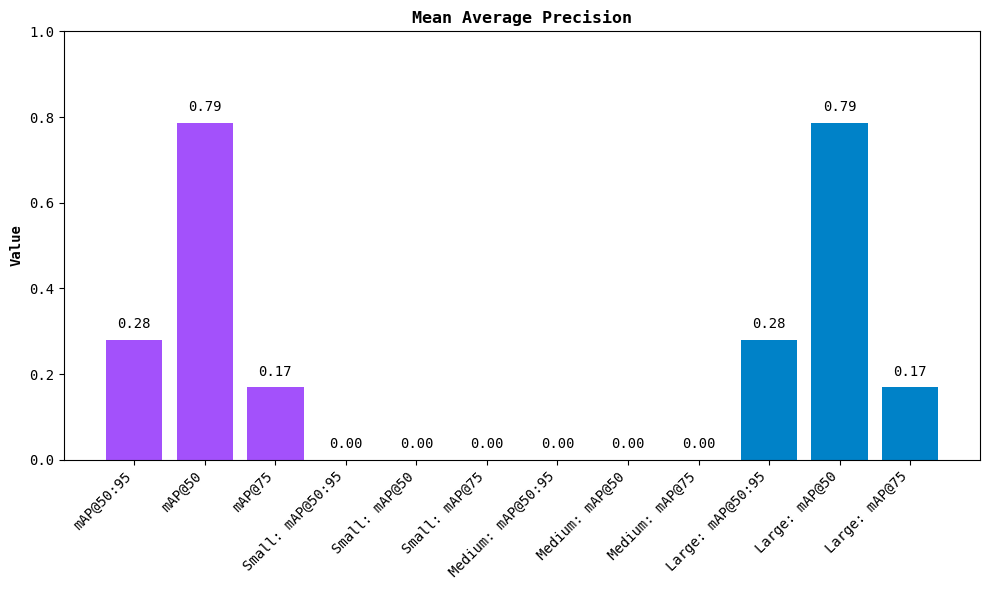

In [40]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [60]:
model = YOLO(model_path)

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

In [45]:
def histogram_equalization(image):
    """
    ทำ Histogram Equalization บนช่อง Value (V) ของภาพ HSV
    """
    # แปลงจาก RGB เป็น HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # แยกช่อง Hue, Saturation, Value
    h, s, v = cv2.split(hsv)

    # ทำ Histogram Equalization บนช่อง V (ความสว่าง)
    v_eq = cv2.equalizeHist(v)

    # รวมกลับเป็น HSV
    hsv_eq = cv2.merge([h, s, v_eq])
    # แปลงกลับเป็น RGB
    image_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

    return image_eq

def white_balance_simple(image):
    """
    Simple white balance by scaling channels based on average intensity
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate the mean for each channel
    mean_r = np.mean(image_float[:,:,0])
    mean_g = np.mean(image_float[:,:,1])
    mean_b = np.mean(image_float[:,:,2])

    # Calculate scaling factors
    scale_r = 128 / mean_r if mean_r > 0 else 1
    scale_g = 128 / mean_g if mean_g > 0 else 1
    scale_b = 128 / mean_b if mean_b > 0 else 1

    # Scale each channel
    image_float[:,:,0] *= scale_r
    image_float[:,:,1] *= scale_g
    image_float[:,:,2] *= scale_b

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)

    return image_balanced

def white_balance_gray_world(image):
    """
    Gray World Assumption white balance method
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate average of each channel
    r_avg = np.mean(image_float[:,:,0])
    g_avg = np.mean(image_float[:,:,1])
    b_avg = np.mean(image_float[:,:,2])

    # Calculate the overall average
    avg = (r_avg + g_avg + b_avg) / 3

    # Calculate scaling factors
    r_scale = avg / r_avg if r_avg > 0 else 1
    g_scale = avg / g_avg if g_avg > 0 else 1
    b_scale = avg / b_avg if b_avg > 0 else 1

    # Apply scaling
    image_float[:,:,0] *= r_scale
    image_float[:,:,1] *= g_scale
    image_float[:,:,2] *= b_scale

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)
    return image_balanced

In [46]:
def detect_color_from_bbox(image, bbox, crop_ratio=0.8):
    """
    Detect average color from bounding box using advanced color analysis

    Args:
    - image: PIL Image
    - bbox: (xmin, ymin, xmax, ymax)
    - crop_ratio: Ratio of bounding box to analyze (default 0.8)

    Returns:
    - Tuple of (hue, saturation, value)
    """
    xmin, ymin, xmax, ymax = bbox
    cropped_img = image.crop((xmin, ymin, xmax, ymax))
    cropped_img = np.array(cropped_img)

    # Convert to HSV
    hsv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2HSV)

    # Apply median blur to reduce noise
    hsv_img = cv2.medianBlur(hsv_img, 5)

    # Crop center of the image
    h, w, _ = hsv_img.shape
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    y_offset, x_offset = (h - new_h) // 2, (w - new_w) // 2
    cropped_center = hsv_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

    # Calculate median values
    avg_hue = np.median(cropped_center[:, :, 0])
    avg_sat = np.median(cropped_center[:, :, 1])
    avg_val = np.median(cropped_center[:, :, 2])

    return avg_hue, avg_sat, avg_val

def identify_color(avg_hue, avg_sat, avg_val):
    """
    Identify color based on HSV values

    Args:
    - avg_hue: Hue value (0-180 in OpenCV)
    - avg_sat: Saturation value (0-255)
    - avg_val: Value/Brightness value (0-255)

    Returns:
    - Color name as string
    """
    # Convert OpenCV HSV to standard HSV
    hue = avg_hue * 2  # OpenCV uses 0-180, standard HSV uses 0-360
    sat = avg_sat / 255 * 100  # Convert to percentage
    val = avg_val / 255 * 100  # Convert to percentage

    # Print debug information
    print(f"🔍 Hue: {hue:.2f}, Saturation: {sat:.2f}%, Value: {val:.2f}%")

    # Check for white, black, or gray conditions
    if val < 20:
        return "Black"
    if sat < 20 or val > 90:
        return "White"

    # Detailed color mapping
    if (hue >= 330 or hue <= 30):  # Red
        return "Red"
    elif 30 < hue < 90:  # Yellow to Green
        if hue < 60:
            return "Yellow"
        else:
            return "Green"
    elif 90 <= hue < 150:  # Cyan to Blue
        if hue < 120:
            return "Cyan"
        else:
            return "Blue"
    elif 150 <= hue < 270:  # Blue to Purple
        if hue < 210:
            return "Blue"
        else:
            return "Purple"
    elif 270 <= hue < 330:  # Magenta to Red
        return "Red2"

    return "Unknown"

In [ ]:
# Main processing function
def process_image(image_path, model, sv):
    # Open and preprocess image
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    # image = Image.fromarray(white_balance_gray_world(np.array(image)))

    # Detect objects
    results = model(image, verbose=False)[0]
    # ปรับค่า IoU threshold ในขั้นตอน NMS
    detections = sv.Detections.from_ultralytics(results).with_nms()


    # Annotate image
    box_annotator = sv.BoxAnnotator(thickness=5)
    label_annotator = sv.LabelAnnotator()
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Count colors
    dict_count = {}
    for i, box in enumerate(detections.xyxy):
        avg_color = detect_color_from_bbox(image, box)
        color = identify_color(*avg_color)

        # Count colors
        dict_count[color] = dict_count.get(color, 0) + 1

    # Print results
    for key, value in dict_count.items():
        print(f"{key}: {value}")

    print(f"Number of detections: {len(detections.xyxy)}")
    print(f"Number of boxes drawn: {len(detections)}")

    # Plot image
    sv.plot_image(annotated_image)

    return dict_count, annotated_image

🔍 Hue: 352.00, Saturation: 61.18%, Value: 50.20%
🔍 Hue: 348.00, Saturation: 50.20%, Value: 49.41%
🔍 Hue: 228.00, Saturation: 20.78%, Value: 33.73%
🔍 Hue: 354.00, Saturation: 82.75%, Value: 23.92%
🔍 Hue: 270.00, Saturation: 32.16%, Value: 24.71%
🔍 Hue: 354.00, Saturation: 89.80%, Value: 18.04%
🔍 Hue: 348.00, Saturation: 45.49%, Value: 22.75%
🔍 Hue: 352.00, Saturation: 83.14%, Value: 21.18%
🔍 Hue: 192.00, Saturation: 9.41%, Value: 34.90%
🔍 Hue: 28.00, Saturation: 6.27%, Value: 34.51%
🔍 Hue: 352.00, Saturation: 88.63%, Value: 16.08%
🔍 Hue: 292.00, Saturation: 11.76%, Value: 32.16%
🔍 Hue: 354.00, Saturation: 92.94%, Value: 12.94%
🔍 Hue: 354.00, Saturation: 89.02%, Value: 21.18%
🔍 Hue: 354.00, Saturation: 90.59%, Value: 12.16%
🔍 Hue: 348.00, Saturation: 38.43%, Value: 22.75%
🔍 Hue: 354.00, Saturation: 89.80%, Value: 14.90%
🔍 Hue: 220.00, Saturation: 9.80%, Value: 36.47%
Red: 7
Purple: 1
Red2: 1
Black: 5
White: 4
Number of detections: 18
Number of boxes drawn: 18


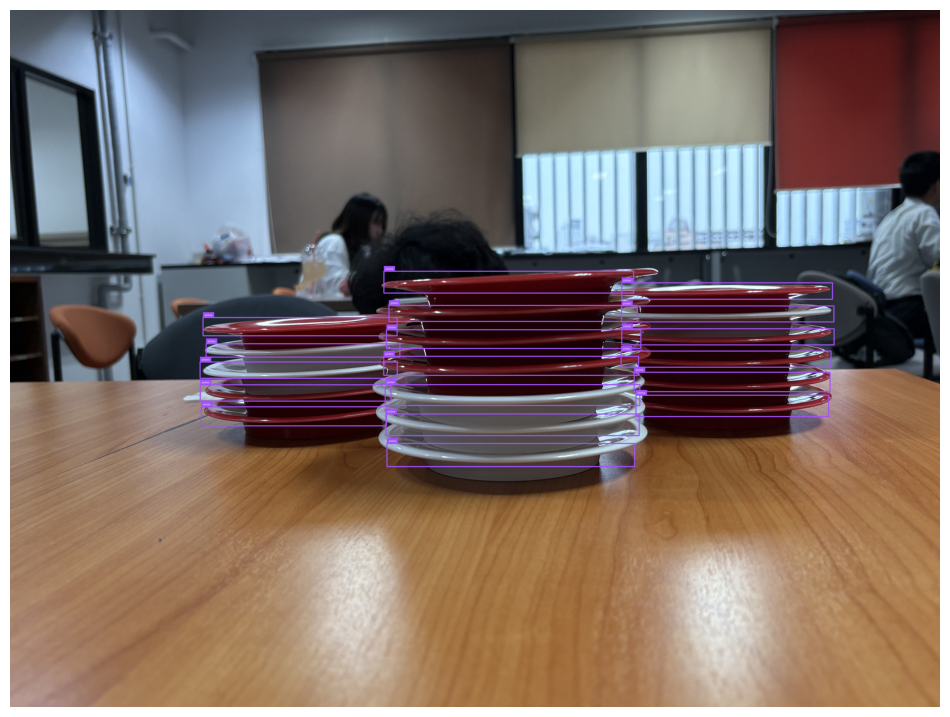

In [ ]:
# predict by your image
image_path = "/content/IMG_2060.JPG"
result_count, result_image = process_image(image_path, model, sv)

🔍 Hue: 4.00, Saturation: 79.22%, Value: 44.31%
🔍 Hue: 2.00, Saturation: 89.41%, Value: 32.55%
🔍 Hue: 4.00, Saturation: 77.25%, Value: 41.18%
🔍 Hue: 4.00, Saturation: 69.41%, Value: 54.12%
🔍 Hue: 4.00, Saturation: 79.61%, Value: 27.45%
Red: 5
Number of detections: 5
Number of boxes drawn: 5


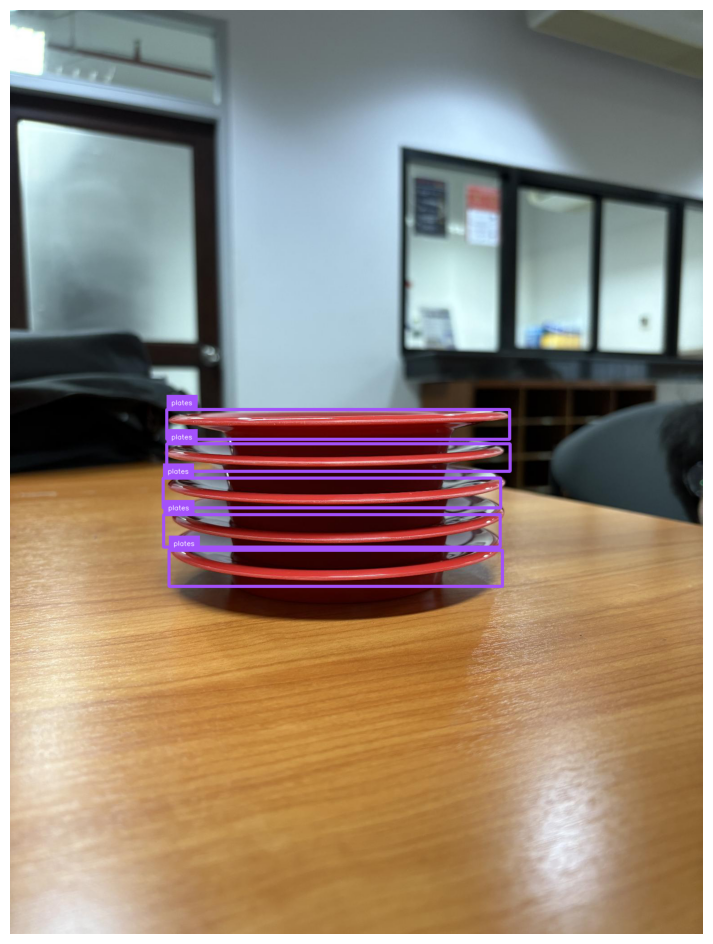

In [ ]:
# predict by test dataset
i = random.randint(0, len(ds))

image_path, image, target = ds[i]

result_count, result_image = process_image(image_path, model, sv)